# Web Scraping Job Vacancies Part 2


At the moment, I am extending the dataset from my previous web scraping project. In this phase, I intend to include major cities in Indonesia to observe the current trends and combine them into a single dataset. I generated a list of large cities programmatically to see the results. Most of the code used below is based on my earlier project, with the main addition being the inclusion of multiple cities to further analyze the effect.

## Step 1: Data Collection and Preparation


In [335]:
# Data handling and cleaning
import pandas as pd
import numpy as np

# Visualization libraries (commonly used for EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Web scraping essentials
import requests
from bs4 import BeautifulSoup

In [336]:
base_url = "https://id.jobstreet.com/id/{keyword}-jobs/in-{location}?page={page}"

jobs = []

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/114.0.0.0 Safari/537.36"
}

In [337]:
# List of big cities in Indonesia with latitude & longitude
indonesia_cities = [
    {"city": "Jakarta", "latitude": -6.2088, "longitude": 106.8456},
    {"city": "Surabaya", "latitude": -7.2575, "longitude": 112.7521},
    {"city": "Bandung", "latitude": -6.9175, "longitude": 107.6191},
    {"city": "Medan", "latitude": 3.5952, "longitude": 98.6722},
    {"city": "Semarang", "latitude": -6.9667, "longitude": 110.4167},
    {"city": "Palembang", "latitude": -2.9761, "longitude": 104.7754},
    {"city": "Makassar", "latitude": -5.1477, "longitude": 119.4327},
    {"city": "Tangerang", "latitude": -6.1783, "longitude": 106.6319},
    {"city": "Depok", "latitude": -6.4025, "longitude": 106.7942},
    {"city": "Bekasi", "latitude": -6.2349, "longitude": 106.9896},
    {"city": "Bogor", "latitude": -6.5971, "longitude": 106.8060},
    {"city": "Malang", "latitude": -7.9839, "longitude": 112.6214},
    {"city": "Denpasar", "latitude": -8.6705, "longitude": 115.2126},
    {"city": "Batam", "latitude": 1.0456, "longitude": 104.0305},
    {"city": "Pekanbaru", "latitude": 0.5071, "longitude": 101.4478},
    {"city": "Padang", "latitude": -0.9471, "longitude": 100.4172},
    {"city": "Banjarmasin", "latitude": -3.3167, "longitude": 114.5908},
    {"city": "Pontianak", "latitude": -0.0263, "longitude": 109.3425},
    {"city": "Manado", "latitude": 1.4748, "longitude": 124.8421},
    {"city": "Yogyakarta", "latitude": -7.7956, "longitude": 110.3695}
]


In [338]:
def create_df_job ( keyword, location, max_page, data):
  MAX_PAGES = max_page #number of page to scan
  base_url = "https://id.jobstreet.com/id/{keyword}-jobs/in-{location}?page={page}"

  for page in range(1, MAX_PAGES + 1):
    url = base_url.format(keyword=keyword, location=location, page=page)
    print("Fetching:", url)

    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print("Error:", response.status_code)
        break

    soup = BeautifulSoup(response.text, "html.parser")
    jobs = soup.find_all("article")

    if not jobs:
        print("No more jobs found, stopping.")
        break

    print(f"Page {page}: {len(jobs)} jobs found")

    for job in jobs:
        title = job.find("a", {"data-automation": "jobTitle"})
        classification = job.find("span", {"data-automation": "jobClassification"})
        company = job.find("a", {"data-automation": "jobCompany"})
        job_location = job.find("a", {"data-automation": "jobLocation"})
        postings = job.find("span", {"data-automation": "jobListingDate"})
        salary = job.find("span", {"data-automation": "jobSalary"})
        job_description = job.find("span", {"data-automation": "jobShortDescription"})

        # print(f"Title: {title.get_text(strip=True) if title else None}")
        # print(f"Company: {company.get_text(strip=True) if company else None}")
        # print(f"Location: {job_location.get_text(strip=True) if job_location else None}")
        # print(f"Posting: {postings.get_text(strip=True) if postings else None}")
        # print(f"Salary: {salary.get_text(strip=True) if salary else None}")
        # print("-" * 40)

        data.append({
              "Title": title.get_text(strip=True) if title else None,
              "Classification": classification.get_text(strip=True) if classification else None,
              "Company": company.get_text(strip=True) if company else None,
              "Location": job_location.get_text(strip=True) if job_location else None,
              "Posting": postings.get_text(strip=True) if postings else None,
              "Salary": salary.get_text(strip=True) if salary else None,
              "Description": job_description.get_text(strip=True) if job_description else None
          })
  return data


In [194]:
import re

def normalize_number(s: str) -> float:
    """
    Convert salary string with commas/dots to float safely.
    Handles '1.000.000,10' and '1,000,000.10'.
    """
    # print(s)
    if s is None:
      return None
    if not re.search(r"\d", s):
      return None

    s = s.strip()

    # Case 1: European/Indonesian format → decimals with comma
    if re.search(r",\d{1,2}$", s):
        s = s.replace(".", "")       # remove thousands separator
        s = s.replace(",", ".")      # convert decimal comma to dot

    # Case 2: US format → decimals with dot
    elif re.search(r"\.\d{1,2}$", s):
        s = s.replace(",", "")       # remove thousands separator

    # Case 3: No decimals → just strip separators
    else:
        s = s.replace(".", "").replace(",", "")

    return float(s)


In [195]:

def parse_salary(s):


    if pd.isna(s):
        return None, None, None,None


    if "per month" in s:
        unit = "month"
    elif "per year" in s:
        unit = "year"
    elif "per hour" in s:
        unit = "hour"
    else:
        unit = None

    if "Rp" in s:
       currency = "IDR"
    elif "$" in s:
        currency = "USD"
        convert = True
    elif "SGD" in s:
        currency = "SGD"
        convert = True
    else:
        currency = None


    s_clean = (s.strip().replace("Rp", "").replace("-", "–").replace("per month", "")
    .replace("per year", "").replace("per hour", "").replace("$", "").replace("(SGD)", "")
    .replace("(USD)", "").replace("IDR", "").replace("RM", "").replace("(MYR)", "")
    )
    low = None
    high = None
    if " – " in s_clean:
      s_clean = s_clean.split(" – ")
      low = s_clean[0]
      high = s_clean[1]
    else:
      low =s_clean
      high = s_clean


    return low,high, unit, currency






In [196]:
df_job = []
for city in indonesia_cities:
  df_job.extend(create_df_job("Any",city["city"], 80))

TypeError: create_df_job() missing 1 required positional argument: 'data'

In [197]:
pd.DataFrame(df_job).to_csv("df_job.csv", index=False)

In [198]:
df_job = pd.read_csv("df_job.csv")
df_job.head()

EmptyDataError: No columns to parse from file

In [199]:
df_job[["Salary_Low","Salary_High", "Unit", "Currency"]] = df_job["Salary"].apply(lambda x: pd.Series(parse_salary(x)))
df_job.head()

TypeError: list indices must be integers or slices, not str

In [ ]:
df_job["Salary_Low"] = df_job["Salary_Low"].apply(lambda x: normalize_number(x))
df_job["Salary_High"] = df_job["Salary_High"].apply(lambda x: normalize_number(x))

In [ ]:
df_job.shape

(11933, 11)

**Amaziingg !!!**

With the maximum pages set for each city, the scraper generated over 11,000 job listings, which is significantly more than the previous dataset of only 2,560 entries. However, some cities do not have 80 pages of job postings, so the process stops earlier (for example, Medan only has 5 pages).

Note: The results may vary depending on the keyword. Currently, I am using the keyword “any” combined with city locations to generate the data. Using different keywords could produce different outcomes. Also, since job postings change over time, the dataset shown above reflects only the current snapshot of available jobs.

In [ ]:
df_job.to_csv("jobstreet_jobs_with_cities.csv", index=False, encoding="utf-8")

print("✅ Job data saved to jobstreet_jobs.csv")

✅ Job data saved to jobstreet_jobs.csv


## Step 2:Exploratory Data Analysis

In [339]:
file_path = 'https://raw.githubusercontent.com/Jasman123/Web_scraping_and_Job_Analyze/main/jobstreet_jobs_with_cities.csv'
df = pd.read_csv(file_path)
df.head()

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency
0,"Customer Service (Jakarta), Operations, SeaBank",(Call Center & Layanan Konsumen),PT Bank Seabank Indonesia,Jakarta Selatan,1 hari yang lalu,NaN,Carry out services to customers such as delive...,NaN,NaN,NaN,NaN
1,Young Professionals Fast Track,"(Manufaktur, Transportasi & Logistik)",Deliveree (PT Angkut Teknologi Indonesia),Jakarta Selatan,1 hari yang lalu,"Rp 6,000,000 – Rp 9,000,000 per month","If you just click apply, you will not receive ...",6000000.0,9000000.0,month,IDR
2,Customer Service and Operation Specialist (Air...,"(Manufaktur, Transportasi & Logistik)",Easy Speed International Logistics Limited,Jakarta Selatan,3 hari yang lalu,"Rp 8,000,000 – Rp 12,000,000 per month",Airfreight customer service and import and exp...,8000000.0,12000000.0,month,IDR
3,Logistic,"(Manufaktur, Transportasi & Logistik)",NaN,Jakarta Raya,23 jam yang lalu,NaN,"Responsible of logistic from receipt, storage...",NaN,NaN,NaN,NaN
4,Customer Service Specialist,(Call Center & Layanan Konsumen),TE Connectivity,Jakarta Raya,16 jam yang lalu,NaN,"Involves demand planning, order management, cu...",NaN,NaN,NaN,NaN


In [340]:
print(f"Number of rows: {df.shape[0]}")
df = df.drop_duplicates()
print(f"Number of rows after removing duplicates: {df.shape[0]}")

Number of rows: 11933
Number of rows after removing duplicates: 5228


The code executes drop_duplicates and shows that a significant portion **(more than 50%)** of the dataset has duplicate entries.

Why does this happen?
One possibility is that some of the cities are very close to each other (for example, Jakarta–Depok, which are about 29 km apart), causing job board openings to be duplicated.

In [341]:
df.dtypes

,0
Title,object
Classification,object
Company,object
Location,object
Posting,object
Salary,object
Description,object
Salary_Low,float64
Salary_High,float64
Unit,object


In [342]:
df.describe()

,Salary_Low,Salary_High
count,7.890000e+02,7.890000e+02
mean,7.521840e+06,9.831156e+06
std,9.526425e+06,1.362238e+07
min,2.500000e+03,3.000000e+03
25%,4.500000e+06,5.500000e+06
50%,6.000000e+06,7.500000e+06
75%,8.000000e+06,1.000000e+07
max,2.000000e+08,3.000000e+08


In [343]:
df.isnull().sum()

,0
Title,0
Classification,0
Company,116
Location,0
Posting,0
Salary,4437
Description,1
Salary_Low,4439
Salary_High,4439
Unit,4440


In [344]:
no_salary = float(df["Salary"].isnull().sum()) / len(df) * 100
print(f"Missing salary values: {no_salary:.2f}%")

Missing salary values: 84.87%


In [345]:
no_company = df["Company"].nunique()
print(f"numbers of company: {no_company}")

numbers of company: 2218


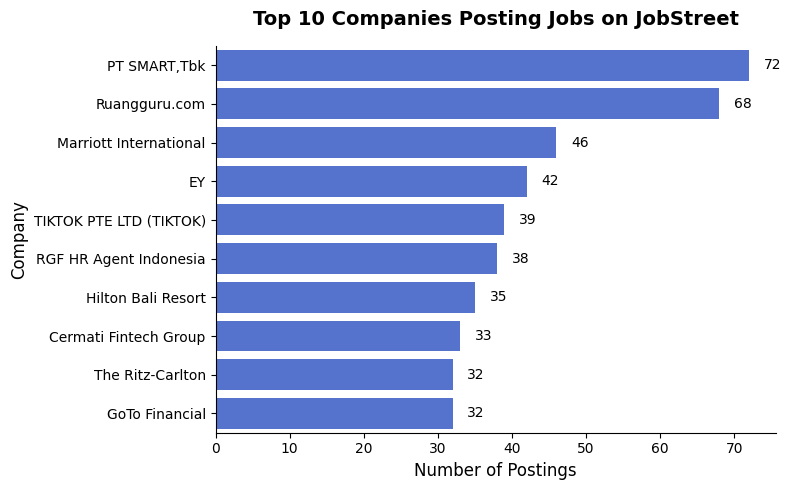

In [346]:
# Top 10 companies with most job postings
df_top10_company = df["Company"].value_counts().head(10)

plt.figure(figsize=(8, 5))
sns.barplot(
    y=df_top10_company.index,
    x=df_top10_company.values,
    color="royalblue"
)

# Add value labels on bars
for i, val in enumerate(df_top10_company.values):
    plt.text(val + 2, i, str(val), va='center', fontsize=10)

# Labels and title
plt.ylabel("Company", fontsize=12)
plt.xlabel("Number of Postings", fontsize=12)
plt.title("Top 10 Companies Posting Jobs on JobStreet", fontsize=14, fontweight="bold", pad=15)

sns.despine()
plt.tight_layout()
plt.show()

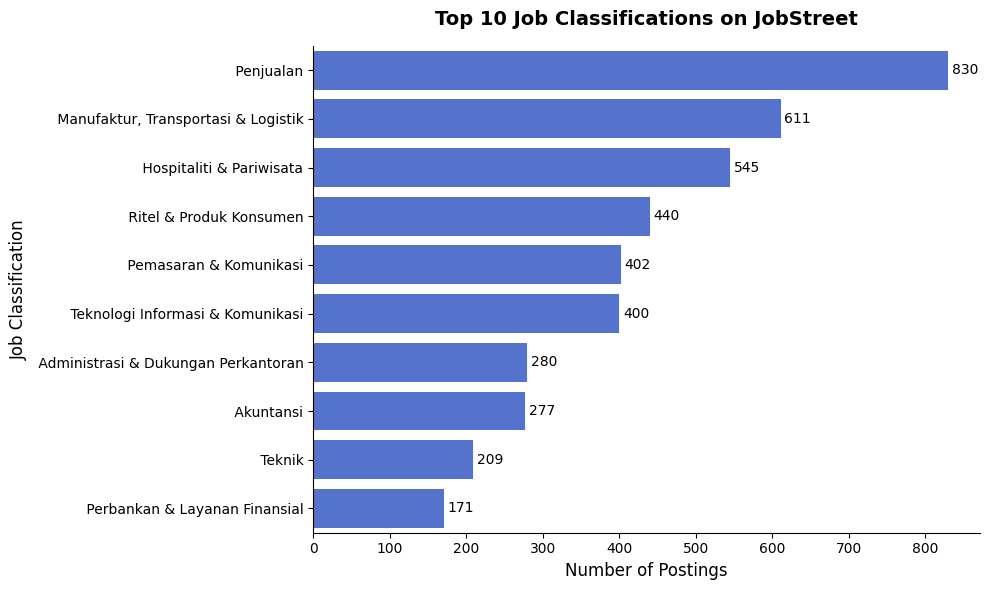

In [347]:
df_top10job = df["Classification"].value_counts().head(10).reset_index()
df_top10job.columns = [ "Classification", "Sum of Postings"]
df_top10job['Classification'] = df_top10job['Classification'].str.replace(
    r"\((.*)\)", r" \1", regex=True
)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=df_top10job,
    y="Classification",
    x="Sum of Postings",
    color="royalblue"
)

# Add value labels
for i, val in enumerate(df_top10job["Sum of Postings"]):
    plt.text(val + 5, i, str(val), va="center", fontsize=10)

plt.ylabel("Job Classification", fontsize=12)
plt.xlabel("Number of Postings", fontsize=12)
plt.title("Top 10 Job Classifications on JobStreet", fontsize=14, fontweight="bold", pad=15)
sns.despine()
plt.tight_layout()
plt.show()

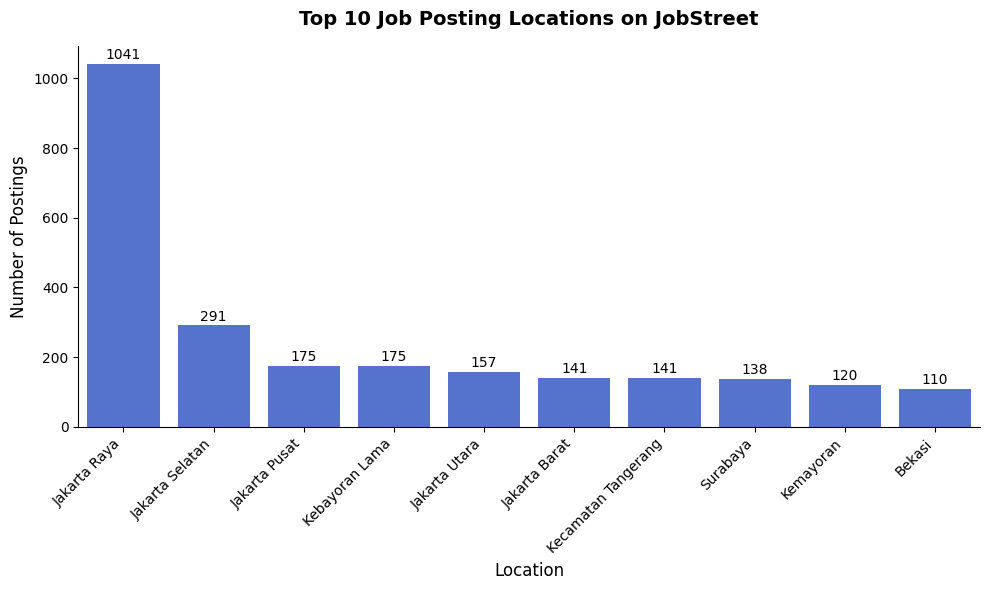

In [348]:
df_top10_location = df["Location"].value_counts().head(10)
# df_top10_location
plt.figure(figsize=(10,6))
sns.barplot(
    x=df_top10_location.index,
    y=df_top10_location.values,
    color="royalblue"  # one consistent color
)

# Add labels on top of bars
for i, val in enumerate(df_top10_location.values):
    plt.text(i, val + 5, str(val), ha='center', va='bottom', fontsize=10)

plt.xlabel("Location", fontsize=12)
plt.ylabel("Number of Postings", fontsize=12)
plt.title("Top 10 Job Posting Locations on JobStreet", fontsize=14, fontweight="bold", pad=15)
plt.xticks(rotation=45, ha="right")
sns.despine()
plt.tight_layout()
plt.show()

In [349]:
df = df[df['Unit']=='month']

In [350]:
max_salary = df['Salary_High'].max()
min_salary = df['Salary_Low'].min()

print(f"Maximum Salary: {max_salary}")
print(f"Minimum Salary: {min_salary}")

Maximum Salary: 130000000.0
Minimum Salary: 2500.0


In [351]:
df_max = df[df['Salary_High'] == max_salary]
df_max

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency
802,Vice President of Corporate Relations,(CEO & Manajemen Umum),PT Humana International Indonesia,Jakarta Raya,6 hari yang lalu,Rp 100.000.000 – Rp 130.000.000 per month,Develop and execute strategies to build and st...,100000000.0,130000000.0,month,IDR


<Axes: xlabel='Salary_Low', ylabel='Count'>

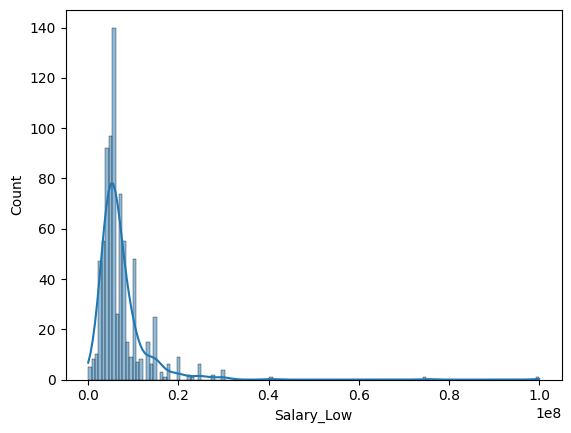

In [352]:
sns.histplot(df['Salary_Low'], kde=True)

In [353]:
q = df['Salary_Low'].quantile(0.01)
df_min = df[df['Salary_Low'] >= q]
min_salary = df_min['Salary_Low'].min()
min_salary

1500000.0

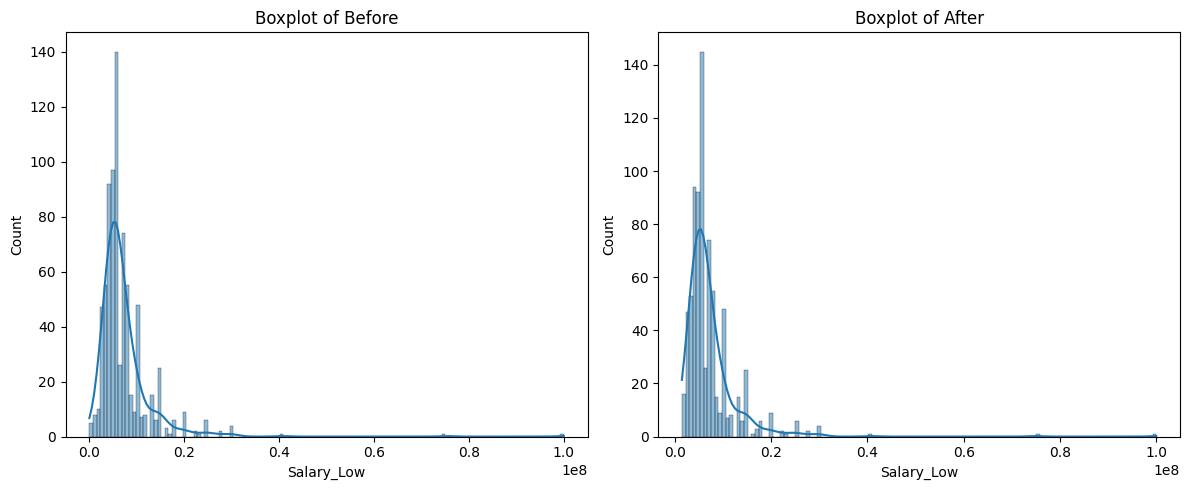

In [354]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data=df, x='Salary_Low', ax=ax[0], kde=True)
ax[0].set_title('Boxplot of Before')

sns.histplot(data=df_min, x='Salary_Low', ax=ax[1], kde=True)
ax[1].set_title('Boxplot of After')

plt.tight_layout()
plt.show()


In [355]:
df_min = df[df['Salary_Low'] == min_salary]
df_min

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency
952,Writer,"(Periklanan, Seni & Media)",PT Aldmic Indonesia,Jakarta Barat,19 jam yang lalu,Rp 1.500.000 – Rp 1.760.000 per month,team work,1500000.0,1760000.0,month,IDR
1324,Graphic Designer Intern,(Desain & Arsitektur),Hey Coco! Creative Agency,Jakarta Barat,14 hari yang lalu,Rp 1.500.000 – Rp 2.000.000 per month,We are Hey Coco! Creative Agency based on West...,1500000.0,2000000.0,month,IDR
1736,Legal Internship,(Hukum),PT Exabytes Network Indonesia,Jakarta Selatan,29 hari yang lalu,Rp 1.500.000 per month,"As a Legal Intern, you will be an integral par...",1500000.0,1500000.0,month,IDR
4061,Writer,"(Periklanan, Seni & Media)",PT Aldmic Indonesia,Jakarta Barat,20 jam yang lalu,Rp 1.500.000 – Rp 1.760.000 per month,team work,1500000.0,1760000.0,month,IDR
11553,Costumer Services Onine,(Call Center & Layanan Konsumen),Pondok Digital,Kubu Raya,19 jam yang lalu,Rp 1.500.000 – Rp 2.200.000 per month,Bekerja sambil beramal dan berdakwah,1500000.0,2200000.0,month,IDR
11633,SOZO - APOTEKER PENANGGUNG JAWAB (MANADO) - NO...,(Kesehatan & Medis),SEVEN Retail Group,Manado,24 hari yang lalu,Rp 1.500.000 – Rp 2.000.000 per month,"Tidak bekerja di klinik secara langsung, hanya...",1500000.0,2000000.0,month,IDR


In [356]:
df['Average_salary'] = (df['Salary_High'] + df['Salary_Low']) / 2

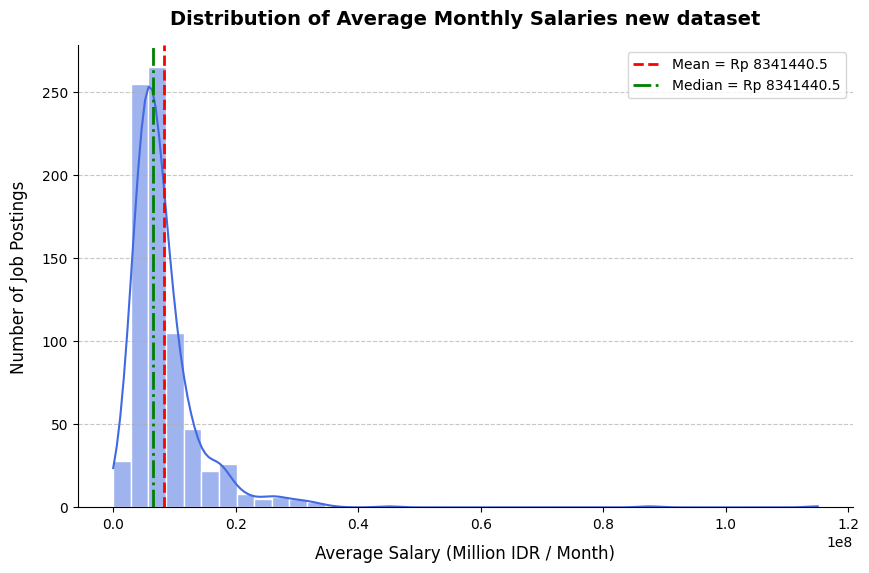

In [357]:
plt.figure(figsize=(10,6))
sns.histplot(df['Average_salary'], bins=40, kde=True, color="royalblue", edgecolor="white")
plt.xlabel("Average Salary (Million IDR / Month)", fontsize=12, labelpad=10)
plt.ylabel("Number of Job Postings", fontsize=12, labelpad=10)
plt.title("Distribution of Average Monthly Salaries new dataset", fontsize=14, fontweight="bold", pad=15)
plt.axvline(df['Average_salary'].mean(), color="red", linestyle="--", linewidth=2, label=f"Mean = Rp {df['Average_salary'].mean():.1f}")
plt.axvline(df['Average_salary'].median(), color="green", linestyle="-.", linewidth=2, label=f"Median = Rp {df['Average_salary'].mean():.1f}")

plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
sns.despine()
plt.show()

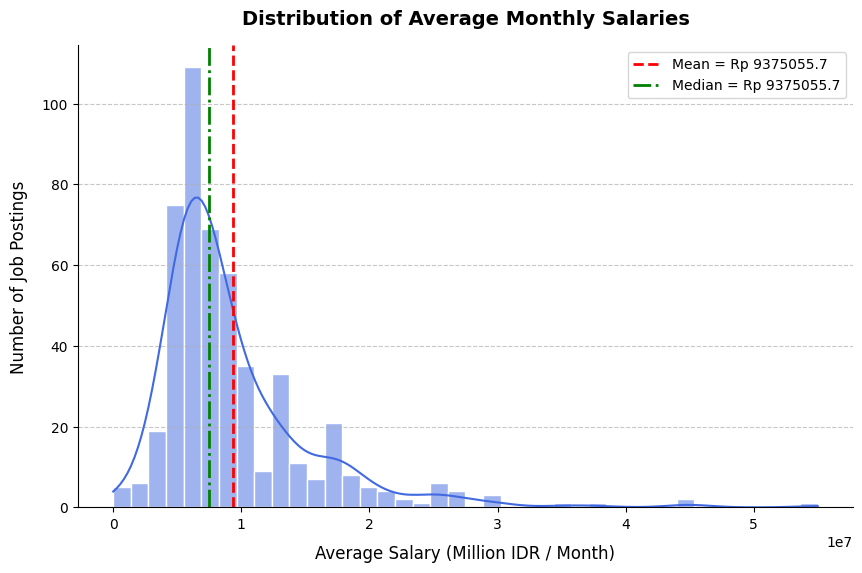

***Insight***

From the two images, we can observe several differences after generating the new dataset for visualization. I would like to highlight a few key points:



1.  **Longer tail in the new dataset:** The first image shows a longer tail compared to the old dataset, extending up to a maximum salary value of around 130 million rupiah, while the previous version only reached about 65 million rupiah.

2. **Shift in mean and median:** Another noticeable change is the shift in the mean and median values between the two graphs. The average salary decreased from approximately 9 million rupiah to 8 million rupiah. This shift occurred because Indonesia applies different minimum wage standards across cities. When these segmented data are compiled together, the mean and median values move leftward. For instance, Jakarta has a monthly minimum wage of Rp 5,396,761, whereas Medan’s is Rp 4,014,072.

## Step 3: Prediction

In [358]:
df.head()

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency,Average_salary
1,Young Professionals Fast Track,"(Manufaktur, Transportasi & Logistik)",Deliveree (PT Angkut Teknologi Indonesia),Jakarta Selatan,1 hari yang lalu,"Rp 6,000,000 – Rp 9,000,000 per month","If you just click apply, you will not receive ...",6000000.0,9000000.0,month,IDR,7500000.0
2,Customer Service and Operation Specialist (Air...,"(Manufaktur, Transportasi & Logistik)",Easy Speed International Logistics Limited,Jakarta Selatan,3 hari yang lalu,"Rp 8,000,000 – Rp 12,000,000 per month",Airfreight customer service and import and exp...,8000000.0,12000000.0,month,IDR,10000000.0
5,Sales Admin,(Administrasi & Dukungan Perkantoran),PT AAF International Indonesia,Jakarta Utara,10 hari yang lalu,"Rp 5,000,000 – Rp 7,000,000 per month",Sales Admin plays a crucial role in supporting...,5000000.0,7000000.0,month,IDR,6000000.0
6,Senior Videographer (Singapore),"(Periklanan, Seni & Media)",Boom Digital Media,Jakarta Raya,14 hari yang lalu,"$5,000 – $7,500 per month (SGD)",This job will be based in Singapore. The work ...,5000.0,7500.0,month,USD,6250.0
8,Customer Service - Assistant Manager,(Call Center & Layanan Konsumen),redBus,Jakarta Raya,1 hari yang lalu,"Rp 11,000,000 – Rp 14,000,000 per month",Hiring for CS Asst. Manager to lead vendor-man...,11000000.0,14000000.0,month,IDR,12500000.0


In [359]:
df.shape

(779, 12)

In [360]:
df['Classification'] = df['Classification'].str.replace(r"\((.*)\)", r" \1", regex=True)

In [361]:
df.head()

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency,Average_salary
1,Young Professionals Fast Track,"Manufaktur, Transportasi & Logistik",Deliveree (PT Angkut Teknologi Indonesia),Jakarta Selatan,1 hari yang lalu,"Rp 6,000,000 – Rp 9,000,000 per month","If you just click apply, you will not receive ...",6000000.0,9000000.0,month,IDR,7500000.0
2,Customer Service and Operation Specialist (Air...,"Manufaktur, Transportasi & Logistik",Easy Speed International Logistics Limited,Jakarta Selatan,3 hari yang lalu,"Rp 8,000,000 – Rp 12,000,000 per month",Airfreight customer service and import and exp...,8000000.0,12000000.0,month,IDR,10000000.0
5,Sales Admin,Administrasi & Dukungan Perkantoran,PT AAF International Indonesia,Jakarta Utara,10 hari yang lalu,"Rp 5,000,000 – Rp 7,000,000 per month",Sales Admin plays a crucial role in supporting...,5000000.0,7000000.0,month,IDR,6000000.0
6,Senior Videographer (Singapore),"Periklanan, Seni & Media",Boom Digital Media,Jakarta Raya,14 hari yang lalu,"$5,000 – $7,500 per month (SGD)",This job will be based in Singapore. The work ...,5000.0,7500.0,month,USD,6250.0
8,Customer Service - Assistant Manager,Call Center & Layanan Konsumen,redBus,Jakarta Raya,1 hari yang lalu,"Rp 11,000,000 – Rp 14,000,000 per month",Hiring for CS Asst. Manager to lead vendor-man...,11000000.0,14000000.0,month,IDR,12500000.0


In [362]:
string_cities = df['Location'].value_counts().to_string()
print(string_cities)

Location
Jakarta Raya           87
Jakarta Selatan        81
Jakarta Utara          56
Jakarta Pusat          48
Bali                   42
Jakarta Barat          39
Badung                 29
Manado                 25
Surabaya               21
Tangerang              17
Semarang               17
Bandung                15
Jakarta Timur          12
Karawang               12
Denpasar               12
Cikarang Pusat         11
Tangerang Selatan      11
Batam                  11
Makassar               10
Palembang              10
Pekanbaru              10
Cikarang Selatan       10
Cikarang                9
Pontianak               9
Bekasi                  8
Medan                   7
Kalimantan Barat        6
Kuta Utara              6
Sidoarjo                6
Jawa Timur              5
Ubud                    5
Denpasar Barat          5
Malang                  5
Padang                  5
Kabupaten Tangerang     5
Banjarmasin             4
Kabupaten Bekasi        4
Banten                  4
Kut

In [363]:
df.loc[df['Location'].str.contains("Jakarta", case=False), 'Location'] = "Jakarta"
df.loc[df['Location'].str.contains("Bekasi", case=False), 'Location'] = "Bekasi"
df.loc[df['Location'].str.contains("Cikarang", case=False), 'Location'] = "Cikarang"
df.loc[df['Location'].str.contains("Bandung", case=False), 'Location'] = "Bandung"
df.loc[df['Location'].str.contains("Bogor", case=False), 'Location'] = "Bogor"
df.loc[df['Location'].str.contains("Depok", case=False), 'Location'] = "Depok"
df.loc[df['Location'].str.contains("Badung", case=False), 'Location'] = "Bandung"
df.loc[df['Location'].str.contains("Tangerang", case=False), 'Location'] = "Tangerang"



In [364]:
string_cities = df['Location'].value_counts().to_string()
top20_cities = df['Location'].value_counts().nlargest(20).index.tolist()
print(top20_cities)

['Jakarta', 'Bandung', 'Bali', 'Tangerang', 'Cikarang', 'Manado', 'Surabaya', 'Semarang', 'Bekasi', 'Karawang', 'Denpasar', 'Batam', 'Pekanbaru', 'Makassar', 'Palembang', 'Pontianak', 'Medan', 'Kuta Utara', 'Kalimantan Barat', 'Sidoarjo']


In [365]:
df = df[df['Location'].isin(top20_cities)]
df.shape

(651, 12)

In [366]:
df.head()

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency,Average_salary
1,Young Professionals Fast Track,"Manufaktur, Transportasi & Logistik",Deliveree (PT Angkut Teknologi Indonesia),Jakarta,1 hari yang lalu,"Rp 6,000,000 – Rp 9,000,000 per month","If you just click apply, you will not receive ...",6000000.0,9000000.0,month,IDR,7500000.0
2,Customer Service and Operation Specialist (Air...,"Manufaktur, Transportasi & Logistik",Easy Speed International Logistics Limited,Jakarta,3 hari yang lalu,"Rp 8,000,000 – Rp 12,000,000 per month",Airfreight customer service and import and exp...,8000000.0,12000000.0,month,IDR,10000000.0
5,Sales Admin,Administrasi & Dukungan Perkantoran,PT AAF International Indonesia,Jakarta,10 hari yang lalu,"Rp 5,000,000 – Rp 7,000,000 per month",Sales Admin plays a crucial role in supporting...,5000000.0,7000000.0,month,IDR,6000000.0
6,Senior Videographer (Singapore),"Periklanan, Seni & Media",Boom Digital Media,Jakarta,14 hari yang lalu,"$5,000 – $7,500 per month (SGD)",This job will be based in Singapore. The work ...,5000.0,7500.0,month,USD,6250.0
8,Customer Service - Assistant Manager,Call Center & Layanan Konsumen,redBus,Jakarta,1 hari yang lalu,"Rp 11,000,000 – Rp 14,000,000 per month",Hiring for CS Asst. Manager to lead vendor-man...,11000000.0,14000000.0,month,IDR,12500000.0


In [367]:
pred_data = df[['Classification', 'Location','Unit','Currency','Average_salary']]
pred_data.head()

,Classification,Location,Unit,Currency,Average_salary
1,"Manufaktur, Transportasi & Logistik",Jakarta,month,IDR,7500000.0
2,"Manufaktur, Transportasi & Logistik",Jakarta,month,IDR,10000000.0
5,Administrasi & Dukungan Perkantoran,Jakarta,month,IDR,6000000.0
6,"Periklanan, Seni & Media",Jakarta,month,USD,6250.0
8,Call Center & Layanan Konsumen,Jakarta,month,IDR,12500000.0


In [368]:
pred_data.describe()

,Average_salary
count,6.510000e+02
mean,8.593843e+06
std,7.384871e+06
min,2.750000e+03
25%,5.250000e+06
50%,6.750000e+06
75%,9.687500e+06
max,1.150000e+08


In [369]:
pred_data.isnull().sum()

,0
Classification,0
Location,0
Unit,0
Currency,1
Average_salary,0


In [370]:
pred_data= pred_data.dropna()

In [371]:
pred_data.isnull().sum()

,0
Classification,0
Location,0
Unit,0
Currency,0
Average_salary,0


In [372]:
pred_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 650 entries, 1 to 11693
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Classification  650 non-null    object 
 1   Location        650 non-null    object 
 2   Unit            650 non-null    object 
 3   Currency        650 non-null    object 
 4   Average_salary  650 non-null    float64
dtypes: float64(1), object(4)
memory usage: 30.5+ KB


In [373]:
dummie_pred_data = pd.get_dummies(pred_data,drop_first=True)
dummie_pred_data.head()

,Average_salary,Classification_ Akuntansi,Classification_ Asuransi & Dana Pensiun,Classification_ CEO & Manajemen Umum,Classification_ Call Center & Layanan Konsumen,Classification_ Desain & Arsitektur,Classification_ Hospitaliti & Pariwisata,Classification_ Hukum,Classification_ Kesehatan & Medis,Classification_ Keterampilan & Jasa,...,Location_Manado,Location_Medan,Location_Palembang,Location_Pekanbaru,Location_Pontianak,Location_Semarang,Location_Sidoarjo,Location_Surabaya,Location_Tangerang,Currency_USD
1,7500000.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,10000000.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,6000000.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,6250.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
8,12500000.0,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [374]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

X = dummie_pred_data.drop('Average_salary', axis=1)
y = dummie_pred_data['Average_salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (520, 44)
Shape of X_test: (130, 44)
Shape of y_train: (520,)
Shape of y_test: (130,)


In [375]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [376]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))

RMSE: 4380371.735467057
R² Score: 0.09471775924283254


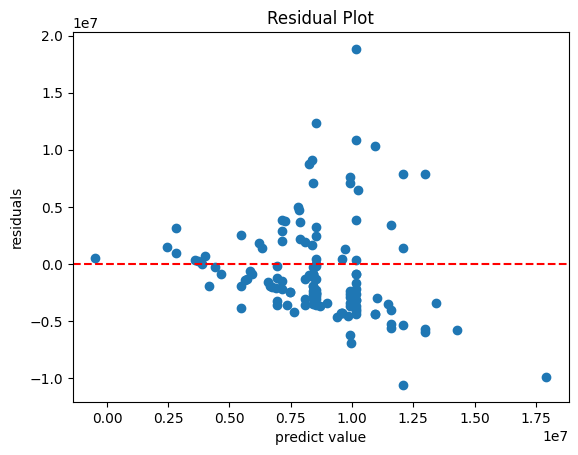

In [377]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('predict value')
plt.ylabel('residuals')
plt.title('Residual Plot')
plt.show()

Standard Deviation of Residuals: 4,346,275


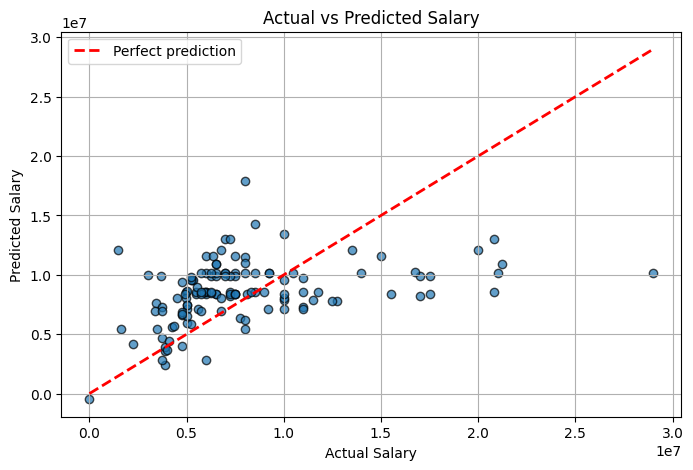

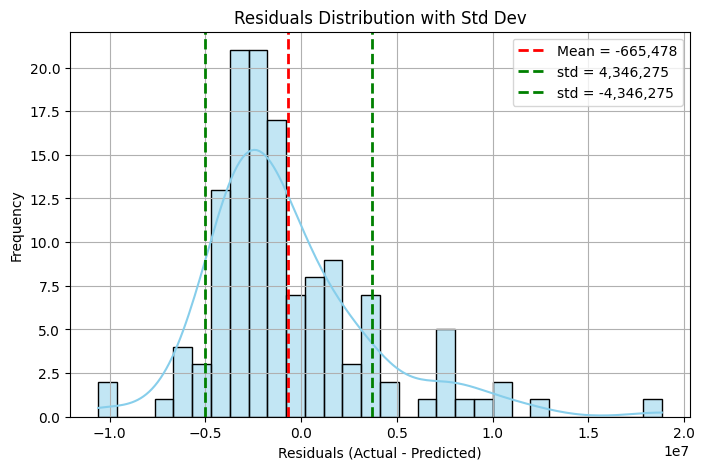

In [378]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residuals (errors)
residuals = y_test - y_pred
std_margin = residuals.std()
print(f"Standard Deviation of Residuals: {std_margin:,.0f}")

# --- Scatter plot: Actual vs Predicted ---
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7)
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs Predicted Salary")

# Reference line (perfect prediction)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2, label="Perfect prediction")

plt.legend()
plt.grid(True)
plt.show()

# --- Residuals distribution with std ---
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30, color="skyblue")

# Add vertical lines for mean and ± std
plt.axvline(residuals.mean(), color='red', linestyle='--', linewidth=2, label=f"Mean = {residuals.mean():,.0f}")
plt.axvline(residuals.mean() + std_margin, color='green', linestyle='--', linewidth=2, label=f"std = {std_margin:,.0f}")
plt.axvline(residuals.mean() - std_margin, color='green', linestyle='--', linewidth=2, label=f"std = {-1*std_margin:,.0f}")

plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residuals Distribution with Std Dev")
plt.legend()
plt.grid(True)
plt.show()


In [379]:
data_compare = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Margin':residuals })
data_compare['Actual']    = data_compare['Actual'].apply(lambda x: f"{x:,.0f}")
data_compare['Predicted'] = data_compare['Predicted'].apply(lambda x: f"{x:,.0f}")
data_compare['Margin']    = data_compare['Margin'].apply(lambda x: f"{x:,.0f}")


data_compare.sort_values(by='Margin', ascending=False)

,Actual,Predicted,Margin
10669,"3,750,000","2,813,061","936,939"
260,"17,500,000","8,365,344","9,134,656"
1790,"17,000,000","8,235,082","8,764,918"
2584,"4,750,000","4,013,445","736,555"
928,"20,000,000","12,099,969","7,900,031"
...,...,...,...
11629,"4,350,000","5,697,683","-1,347,683"
3958,"6,750,000","8,064,062","-1,314,062"
779,"7,250,000","8,532,581","-1,282,581"
2285,"5,750,000","6,940,642","-1,190,642"


In [380]:
summary_pred = pd.concat([df, data_compare], axis=1)
summary_pred = summary_pred.dropna()
summary_pred.head()

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency,Average_salary,Actual,Predicted,Margin
5,Sales Admin,Administrasi & Dukungan Perkantoran,PT AAF International Indonesia,Jakarta,10 hari yang lalu,"Rp 5,000,000 – Rp 7,000,000 per month",Sales Admin plays a crucial role in supporting...,5000000.0,7000000.0,month,IDR,6000000.0,"6,000,000","8,532,581","-2,532,581"
11,Outbound Document Staff,Administrasi & Dukungan Perkantoran,PT. Dynamic Container Lines (Wan Hai Lines (S...,Jakarta,1 hari yang lalu,Rp 5.300.000 – Rp 6.500.000 per month,We provide opportunities to advance your caree...,5300000.0,6500000.0,month,IDR,5900000.0,"5,900,000","8,532,581","-2,632,581"
20,Associate Marketing Communications Manager,Pemasaran & Komunikasi,PT Garmin Indonesia Distribution,Jakarta,22 jam yang lalu,Rp 14.000.000 – Rp 20.000.000 per month,The ideal candidate will possess a deep unders...,14000000.0,20000000.0,month,IDR,17000000.0,"17,000,000","9,911,437","7,088,563"
61,Logistic and/or Sales Admin Staff,Administrasi & Dukungan Perkantoran,PT Pintu Mas Mulia Kimia,Jakarta,13 hari yang lalu,"Rp 5,500,000 – Rp 7,000,000 per month",-,5500000.0,7000000.0,month,IDR,6250000.0,"6,250,000","8,532,581","-2,282,581"
91,Account Executive,Penjualan,PT. Tiki Jalur Nugraha Ekakurir ( JNE),Jakarta,1 hari yang lalu,Rp 5.000.000 – Rp 6.500.000 per month,"Competitive salary, performance bonuses, and c...",5000000.0,6500000.0,month,IDR,5750000.0,"5,750,000","10,167,183","-4,417,183"


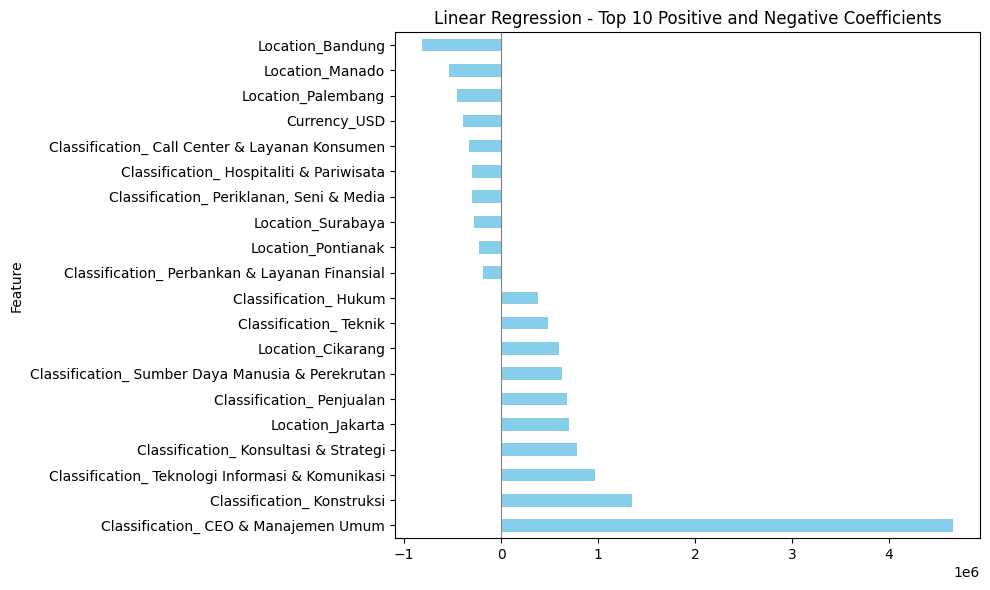

In [381]:
coefs = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

# Plot top 10 positive and negative coefficients
plt.figure(figsize=(10, 6))
top_features = pd.concat([coefs.head(10), coefs.tail(10)])
top_features.set_index('Feature')['Coefficient'].plot(kind='barh', color='skyblue')
plt.title("Linear Regression - Top 10 Positive and Negative Coefficients")
plt.axvline(0, color='gray', linewidth=0.8)
plt.tight_layout()
plt.show()

In [382]:
check_df = summary_pred[summary_pred['Location'] == "Surabaya"]
check_df.head()

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency,Average_salary,Actual,Predicted,Margin
2384,SALES MANAGER,Penjualan,PT NAGAMAS BAN,Surabaya,29 hari yang lalu,Rp 10.000.000 – Rp 12.000.000 per month,"INSENTIF, BONUS, TRANSPORTASI, LAPTOP",10000000.0,12000000.0,month,IDR,11000000.0,"11,000,000","7,139,088","3,860,912"
2390,Buyer Merchandise,Ritel & Produk Konsumen,PT. Niaga Aneka Mode,Surabaya,7 hari yang lalu,Rp 4.750.000 – Rp 5.750.000 per month,Join our dynamic team as a Merchandising Speci...,4750000.0,5750000.0,month,IDR,5250000.0,"5,250,000","5,849,399","-599,399"
2464,Customer Support Computer Specialist,Teknologi Informasi & Komunikasi,PT Quadra Luminari,Surabaya,22 jam yang lalu,Rp 2.500.000 – Rp 3.500.000 per month,"PT Quadra Luminari tawarkan karier stabil, ski...",2500000.0,3500000.0,month,IDR,3000000.0,"3,000,000","9,959,710","-6,959,710"
2569,助理销售经理 / Assistant Sales Manager (Mandarin Spe...,Penjualan,PT. OFERO TECHNOLOGY INDONESIA,Surabaya,14 hari yang lalu,Rp 8.000.000 – Rp 12.000.000 per month,-,8000000.0,12000000.0,month,IDR,10000000.0,"10,000,000","7,139,088","2,860,912"


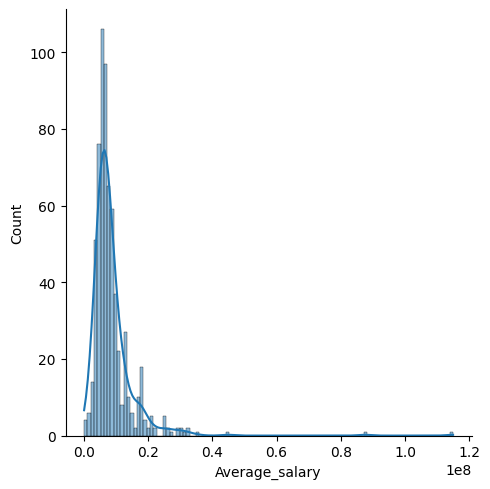

In [383]:
sns.displot(pred_data['Average_salary'], kde=True)